# **4.1. Experiments on training with MMD only on synthetic target data on a single-class setting**
During this set of experiments we will train the full working pipeline using the Unity subprocess running in the background. The pipeline will only be trained using the Maximum Mean Discrepancy loss, in the hopes that the architecture will learn to fit a random distribution to a fixed distribution. These two distributions will be synthetic RGB images of 128x128 pixel resolution. We initially fit a synthetic target distribution so we can get rid of any randomness in the data that hinders Meta-Sim's ability to fit a target distribution. This way we can make sure that Meta-Sim can fit an initial simple target distribution.

## **4.1.1. Learning to rotate an object 90 degrees**
In our case, the random distribution will be a set of images from an object in a Unity 3D scene rotated according to a prior normal distribution of arbitrary parameters, and the fixed (target) distribution will be a set of images from the same object in the 3D scene rotated 90 degrees. The graph representation of the probabilistic grammar used for this set of experiments is shown below _show graph figure of probabilistic grammar_. This set of experiments will consist on extensively exploring Meta-Sim's ability to learn a target custom distribution using a different 3D scene than the one used in the original study. We will first explore how the architecture fits different types of target distributions, departing from different types of initial distributions of graphs. This will allow us to understand which is the best type of distribution we should use for the architecture to work properly. We will later on experiment with ways to improve the architecture's learning performance for wider distributions.

#### Library imports
Let us import all relevant libraries to analyse our results from each of the experiments.

In [1]:
import pandas as pd
import cv2
import random
import yaml
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import os
import json
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from tqdm import tqdm_notebook as tqdm

### **Helper functions**
Let us define all the functions that will help in this study.

In [3]:
from utils.helpers.distribution import *
from utils.helpers.feature_maps import *
from utils.helpers.gcn import *
from utils.helpers.mmd import *
from utils.helpers.read_write import *
from utils.helpers.shared import *

#### Gradients and MMD helper functions
Helper functions to plot data about the training progress.

### **4.1.1.1. Fitting a dirac target distribution with the same configuration than MNIST, but on our Unity 3D scene**
The first experiment we will conduct will be training the Meta-Sim architecture only on MMD with the same hyperparameters as the previous MNIST experiments (see section 3.2.2.), but adapted for the Unity renderer to generate images of a given 3D scene. The hyperparameters for all the experiments are explained in detail in Appendix X. In all following experiments we will only use the last pooling layer of the Inception network to compare the generated distribution to the target distribution using MMD. This experiment will focus on using the pre-defined MNIST distribution of the 'yaw' parameter and trying to fit it to a dirac impulse centered around 90 degrees. 

In [137]:
ROOT_PATH = "../results/single/1_attr"
RESULTS_PATH = "figures/single/1_attr/4_1_1_1"

According to the methodology define in section 3.4, we start by analyzing (1) the GCN's performance during its pre-training phase, and (2) how the graphs are being reproduced as the network trains. This will allow us to understand (1) if the GCN's pre-training is affecting the downstream performance of the network at fitting a target distribution, and (2) if the feature representation of the network is evolving towards a fixed distribution. We plot the losses from the GCN autoencoder training. The following behavior is also observed for the next two sections, and this behavior also applies for them.

/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


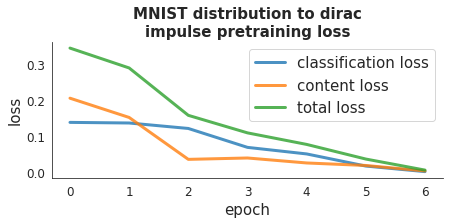

In [25]:
fig = plot_pretraining_progress(
    experiment_n=1,
    title="MNIST distribution to dirac\nimpulse pretraining loss",
    filename="MNIST2dirac_GCN_progress",
    size=(7, 2.5),
)

From these results we can see that the same behavior as in the MNIST case is observed. The architecture learns how to classify each node (class loss), and how to construct the value of each node (cont loss). The total loss is the sum of both losses. The value converges to a low of under ~0.05. We will pay close attention to this value, since it could be the case that the pre-training of the architecture on such a simple graph is harmful to the learning during the MMD training stages.After the pre-training stage, we train the architecture for 500 epochs with the task of fitting a dirac distribution on 90 degrees. 

As per the probabilistic grammar shown above, we observe that there are 4 definite nodes, out of which all attributes are mutable, except for the _yaw_ attribute which is mutable on the 3rd node belonging to the object node. As explained before, the GCN learns to reproduce a featurized representation of the graphs sampled from the probabilistic grammar. This featurized representation is reproduced by batches of size _batch\_sizexnodes\_numberxfeatures\_number_. We can therefore grab those matrices and map them to a lower dimensional space using PCA (_provide citation_), and observe how each node is represented. We can further plot how this representation evolves every 100 epochs in the training.

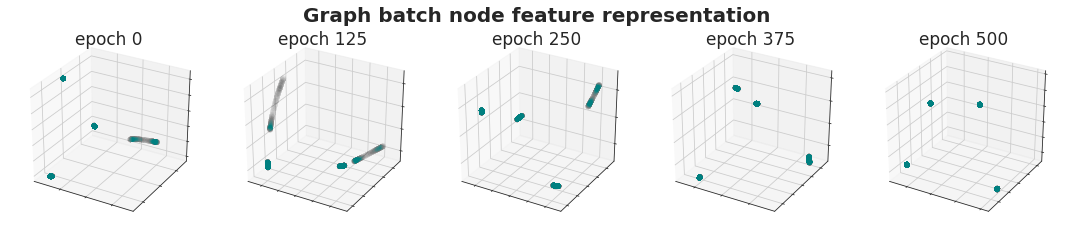

In [136]:
# Plot feature representation
plot_gfeature_representation(
    experiment=1, components=3, interval=5, filename="MNIST2Dirac_gfeatures"
)

From this plot we can observe an initial desired behavior in epoch 0, where 3 nodes are static in space, and the 4th one varies. We assume this node is the one belonging to the object with the modifiable attribute yaw. As the architecture evolves and learns, we would hope to see the 4th node vary, and the rest remain static, until convergence is reached and the target distribution is learned. This however is not the case, from epoch 200 to epoch 400, the 4 nodes move along the space with no aparent pattern, to finally remain static at epoch 500. We further investigate the evolution of the generated distribution in the following study.

We now focus on understanding how the generated _yaw_ value samples from the trained GCN change as it is trained only on the MMD loss. We further compare these to the target distribution, to understand how the generated distribution is shifting with repect to the target, given that the graph feature representations were not behaving as expected. We plot the distributions below every 100 epochs, to understand how they are shifting as the architecture trains.

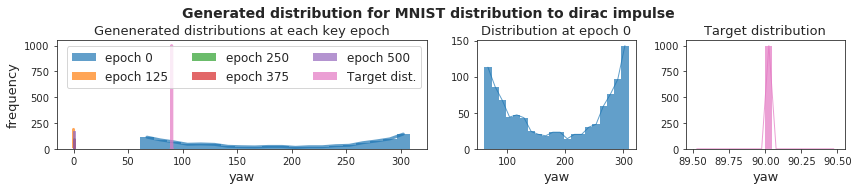

In [127]:
plot_initial_distributions(
    experiment_n=1,
    interval=5,
    parameter="yaw",
    title="Generated distribution for MNIST distribution to dirac impulse",
    filename="MNIST2Dirac_yawdist",
)

From the plots we can see that the target distribution is indeed a dirac impulse at 90 degrees. And the other generated distributions are collapsing to angles very close to 0. We can also observe some kind of shifted normal distribution. After further investigation the initial grammar was defined with the yaw parameter as a Gaussian centered around 0 degrees, with standard deviation of 90 degrees, and maximum value of 360 degrees. After sampling, the architecture takes the modulus of the sampled value and the maximum value

$$yaw  = modulus(sample\_yaw, max\_value) $$

According to this, any negative value will be mapped to a the positive remainder between the value and the maximum value. This indeed inverts the distribution.
Without looking at the behavior of the MMD loss, we can now conclude that the architecture is not learning. Even if the loss was not converging, or if it were random, we have to look at the generated distributions to observe how they compare to the target distribution. We can further do this by plotting the feature maps generated by the Inception network, by pllotting them to a shared space using T-SNE (_provide citation_). 

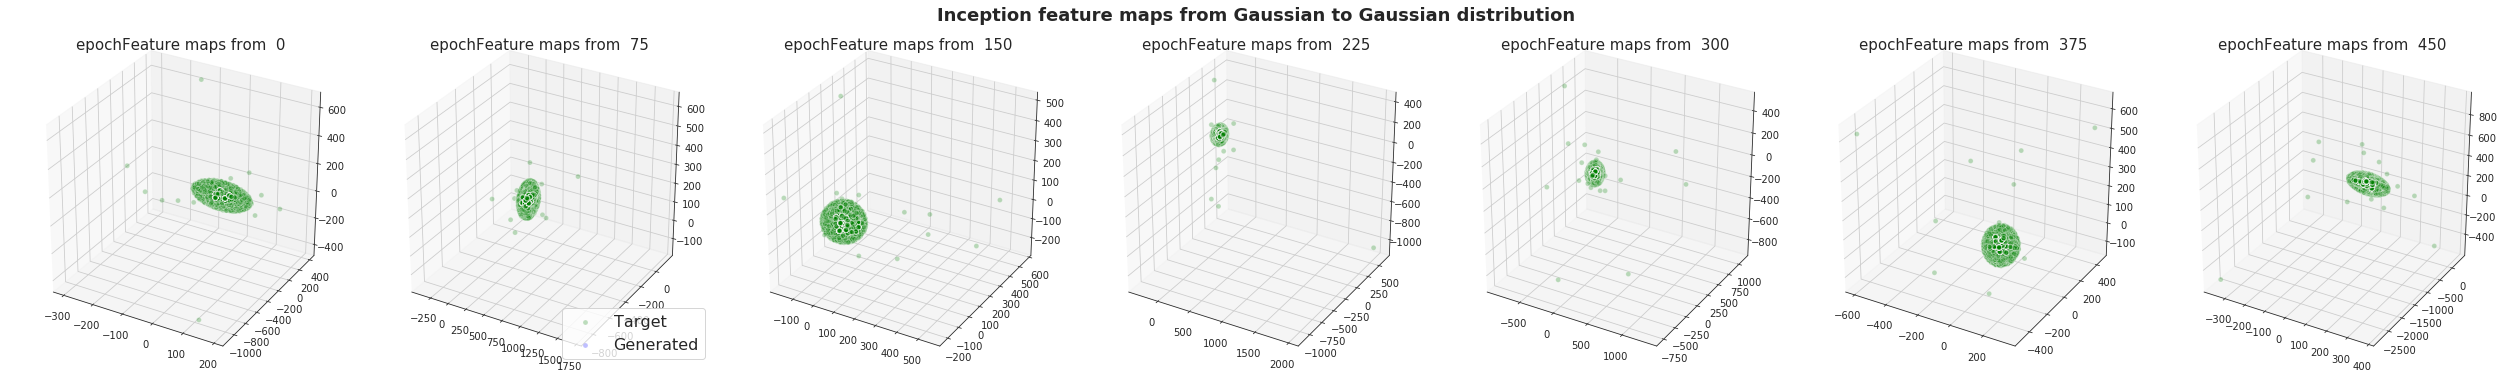

In [520]:
plot_feature_representation(
    experiment=1,
    components=3,
    interval=3,
    filename="MNIST2Dirac_inception_fmaps",
    title="Inception feature maps from Gaussian to Gaussian distribution",
)

From these distributions we can see that the generated distribution is still incompatible with the target distribution. The Dirac impulse is represented a a blob in the feature T-SNE space, in the following experiments we will replace the target distribution to be a Gaussian distribution of pre-defined mean and standard deviation, so the distribution matching can be from Gaussian to Gaussian, and not from Gaussian to Dirac, which overcomplicates the problem.

As we have seen from the previous results, the network doesn't seem to be learning to fit a target distribution. It seems to be suffering from node collapse (_check citation_), which hints that the learning is getting stuck in local minima. Let us confirm this by looking at the MMD loss behavior through the epochs, and the gradient flow of every batch, at every epoch. This can be seen in the following two figures.

/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


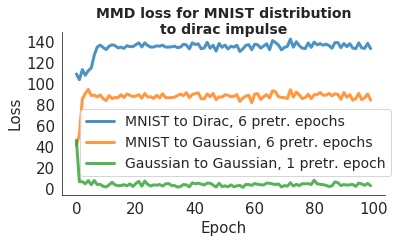

In [138]:
labels = [
    "MNIST to Dirac, 6 pretr. epochs",
    "MNIST to Gaussian, 6 pretr. epochs",
    "Gaussian to Gaussian, 1 pretr. epoch",
]
sns.set_style("white")
fig, ax = plt.subplots(figsize=(5.8, 3))
exp_list = [1, 2, 3]
for i, exp in enumerate(exp_list):
    plot_MMD_loss_joint(experiment_n=exp, label=labels[i], limit=100)
    plt.legend(bbox_to_anchor=(1.04, 0.57), loc="upper right", fontsize=14)
plt.title(
    f"MMD loss for MNIST distribution\nto dirac impulse",
    fontweight="bold",
    fontsize=14,
    y=0.95,
)
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
sns.despine(left=False, bottom=False)
plt.show()
fig.savefig(
    os.path.join(RESULTS_PATH, f"DistMatchingDirac_MMD_loss.pdf"),
    bbox_inches="tight",
    pad_inches=0.1,
)

/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


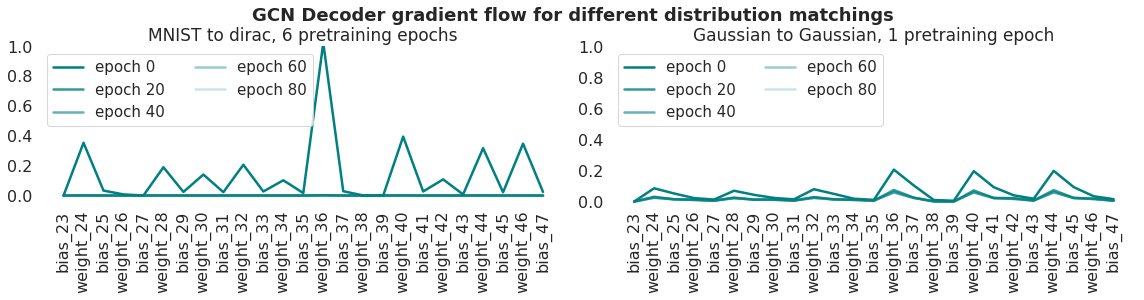

In [337]:
# Plot grid of distributions
titles = [
    "MNIST to dirac, 6 pretraining epochs",
    "Gaussian to Gaussian, 1 pretraining epoch",
]
# Experiment list
exp_list = [1, 3]
# Plot distribution grid
plt.suptitle(
    "GCN Decoder gradient flow for different distribution matchings",
    fontsize=18,
    fontweight="bold",
    y=1.03,
)
for i, exp in enumerate(exp_list):
    fig = plot_gradients_grid(
        experiment_n=exp,
        rows=1,
        columns=2,
        interval=20,
        size=(16, 4),
        limit=100,
        alpha_mult=0.01,
        title=titles[i],
        i=i,
    )
    plt.xticks(rotation=90, fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylim(top=1)

plt.tight_layout()
plt.show()
fig.figure.savefig(
    os.path.join(RESULTS_PATH, f"DistMatching_gradient_flow.pdf"),
    bbox_inches="tight",
    pad_inches=0.1,
)

Indeed, we can see that after 5 epochs, the gradients are always practically 0 in the decoder part of our GCN network, at every one of its layers. This is a clear sign that the architecture is not learning anymore, and it is just stuck in a local optimum. 

### **4.1.1.2. Fitting a Gaussian ditribution with the same configuration than MNIST, but on our Unity 3D scene**
Since the dirac target distribution forces mode collapse in the network's training, we will address this by having a normal distribution of mean 90 degrees, and standard deviation 10 degrees, as our target distribution. We will run this experiment for 100 epochs. We observe the same total loss behavir than before, since we didn't change the number of reconstruction epochs. Let's look at the distribution of the generated samples to see how the generated distributions behaved after 100 epochs of training, every 25 epochs.

In [97]:
RESULTS_PATH = "figures/single/1_attr/4_1_1_2"

Full results not ready yet


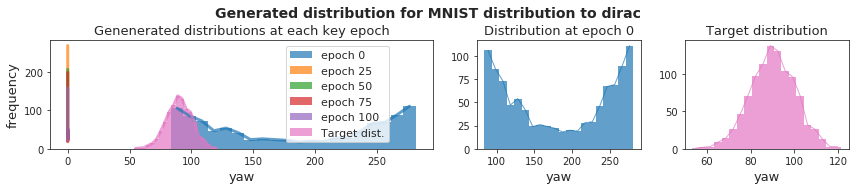

In [98]:
plot_initial_distributions(
    experiment_n=2,
    interval=1,
    parameter="yaw",
    title="Generated distribution for MNIST distribution to dirac",
    filename="MNIST2Gaussian_yawdist",
)

As we can see, the same type of mode collapse is happening, and, since we didn't change the probabilistic grammar, the same type of "inverted Gussian" effect is observed on each distribution. We can further confirm no learning from the generated images.

Full results not ready yet


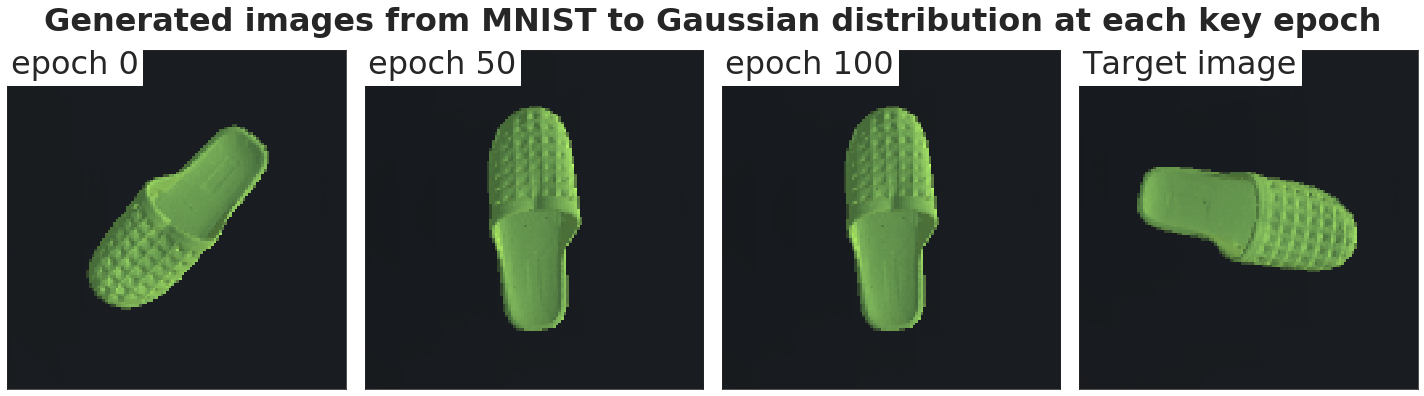

In [99]:
plot_each_image(
    experiment_n=2,
    interval=2,
    filename="MNIST2Gaussian_images",
    title="Generated images from MNIST to Gaussian distribution at each key epoch",
)

We can further conclude mode collapse by looking at the MMD loss, and the gradient behavior through the Graph Convolutional Network. Which can be seen in Figure X. Along with the gradients from the other two experiments. In this case, the MMD loss seems to have reached a local optimum in a lower loss than the previous experiment, but still a much higher point than desired, and still at angle of 0 degrees. As we can see, the gradients are collapsing much quicklier this time, compared to the previous experiment. The gradients however, are almost half smaller than the previous experiment. This seems to be due to the target distribution being much more spread out than the dirac distribution used in the previous experiment. Let us confirm this by looking at the distribution of generated distribution maps. 

Full results not ready yet


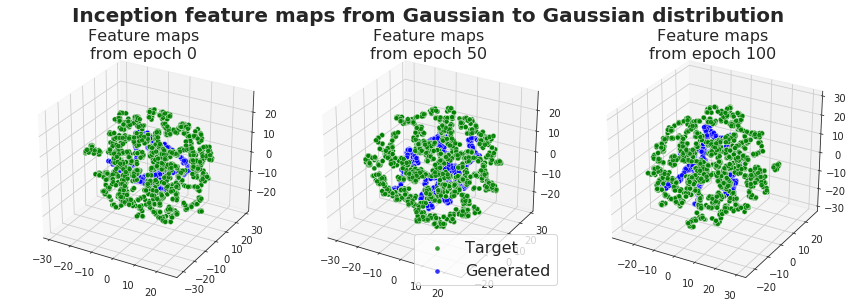

In [96]:
plot_feature_representation(
    experiment=2,
    components=3,
    interval=2,
    filename="MNIST2Gaussian_inception_fmaps",
    title="Inception feature maps from Gaussian to Gaussian distribution",
)

We can quickly notice that the target distribution feature representation has significantly changed, thanks to the shift from a dirac impulse to a Gaussian distribution. Also, both distributions seem to be in the same general space, compared to the previous with the dirac impulse, where both 3D distributions where completely far from each other. Also, in future experiments we will keep an eye on the number of samples we use for comparison, because we can evidently see that, thanks to the generated batch size of 50, versus the target batch size of 200, there are much more green samples, than blue ones. This must affect the distribution fitting. 

### **4.1.1.3. Fitting a Gaussian ditribution departing from a Gaussian distribution, with 1 pre-training epoch**
Given that the previous initial distribution used in the probabilistic grammar provided an inverted Gaussian, we define a new initial distribution of mean 180, standard deviation of 10, and maximum value of 360. This will avoid the modulus effect we observed previously. Additionally, we hypothesize that the GCN pretraining is harmful to the stability of the MMD learning in such a simple case. For this and the past experiment, the graph representation has only 4 nodes, and 9 features, compared to the MNIST case where there are 18 features. We hope that, by pre-training the GCN for 1 epoch, the MMD training will converge towards a sensible mean. We hypothesize this because of the gradient behavior we observed previously, where the gradients are vanishing after just a couple epochs. This means that the MMD learning is getting stuck at a local minimum, and doesn't learn anymore.

Let's first look at the generated samples to understand whether the architecture is (1) generating Gaussian distributions, and (2), attempting to fit the target distribution.

In [504]:
RESULTS_PATH = "figures/single/1_attr/4_1_1_3"

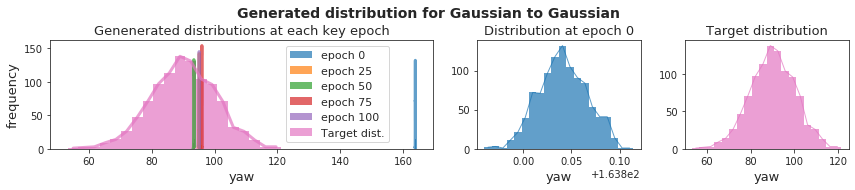

In [146]:
plot_initial_distributions(
    experiment_n=3,
    interval=5,
    parameter="yaw",
    title="Generated distribution for Gaussian to Gaussian",
    filename="G2G_yawdist",
)

As we can see, the architecture finally attempts to fit the target distribution by shifting its mean from ~165 degrees, to around 90 degrees at epoch 40. This is an important improvement with respect to the previous architecture configurations, since it now learns to generate images that look more like the target ones. We can verify this by looking at the generated images. So what is important here is that the architecture is learning the target mean succesfully. It is not learning the standard deviation of the target distribution, but this is to be expected, according to the paper _give a more thorough explanation of this_. In any case, the generated distribution at epoch 0 _is_ a Gaussian, just a very narrow Gaussian.

Let's further confirm the performance of this network by plotting the generated images, compared to a randomly sampled target image. 

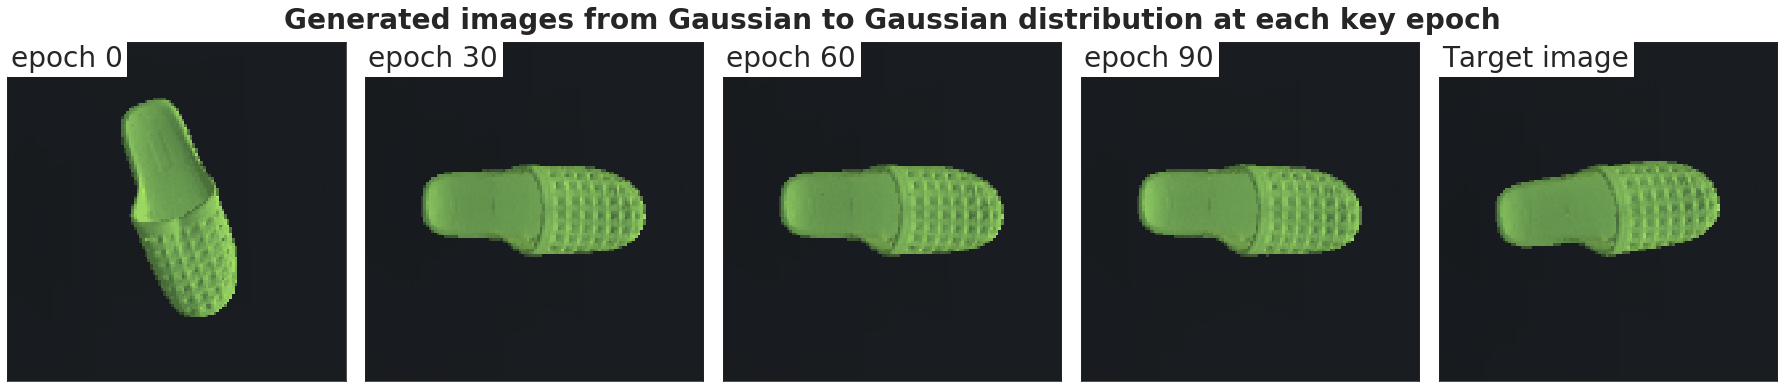

In [430]:
plot_each_image(
    experiment_n=3,
    interval=6,
    filename="G2G_images",
    title="Generated images from Gaussian to Gaussian distribution at each key epoch",
)

The distribution of feature maps doesn't seem to show the clear improvement in performance that the MMD and images showed. In the 2D representation there seems to be more overlap with respect to the previous experiment, but no clear, aparent change is evident. Maybe we can move to representing the feature maps with a different method than T-SNE such as local linear embbedding (reference paper). T-SNE seems to be good for differentiating among classes, but not for fine grained distribution, or distance representation. We could also, actually use PCA.

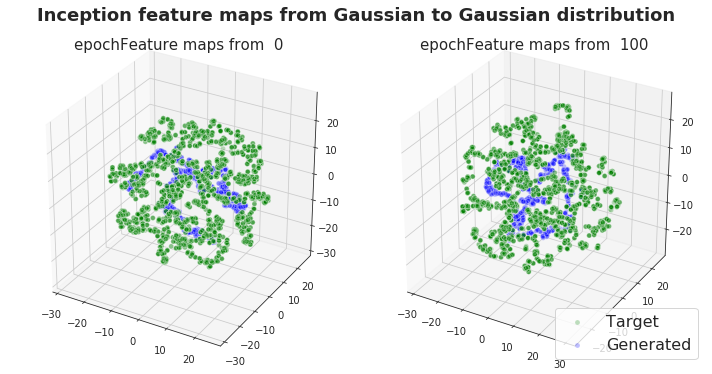

In [515]:
plot_feature_representation(
    experiment=3,
    components=3,
    interval=20,
    filename="G2G_inception_fmaps",
    title="Inception feature maps from Gaussian to Gaussian distribution",
)

Indeed, the architecture learns the target angle successfully after 20 epochs, even though it doesn't quite learn the target distribution just yet. We can further confirm learning by plotting the MMD loss, and investigating the gradient flow through the GCN network, this can be seen in Figure X, where it is compared to the previous two experiments. It is clear that the loss is converging, and gets to a low around ~2. 

As we can see, the architecture effectively reduces the loss and finds a local minimum, where the learning seems to be choppy. We can further investigate this by looking at the gradients below, where epoch 0 experiences a high gradient, and therefore the drop in loss above. The learning is indeed choppy in this case, it must have to do with the learning rate, which in this case has no decay and stays at a value of 0.001. In future experiments we will investigate using other learning rate decay values, so the learning is more stable.

Indeed, the gradient flow seems much more healthy, where the gradients don't vanish immediately, but there is a gradual convergence towards the local minima located at an angle of ~90 degrees. This configuration seems to be the correct one for this experiment to work. However, this exploration gives us clear evidence that the Meta-Sim architecture is not a very robust architecture when it comes to other custom cases, different than the MNIST case, let's investigate this claim further by attempting to widen the generated distribution.

### **4.1.1.4. Attempting to widen the generated distribution** 
As we saw from the previous experiment, the architecture is indeed learning a sensible mean of the target distribution, but it isn't learning, or even generating a distribution with a wider standard deviation. We will attempt multiple strategies in the hopes of the architecture learning to generate a wider distribution centered around ~90 degrees.

### **4.1.1.4.1. Increasing the number of pre-training epochs and using learning rate decay**
According to the paper, and to previous experiments, it is indeed evident that it is during the pre-training phase that the GCN learns to generate a wider distribution, which is the one specified in the probabilistic grammar. This however, in our case, has shown to unstabilize learning of the target mean. In this set of experiments we gradually increase the number of reconstruction epochs to widen the generated distribution, while trying to learn the correct mean.

We will start by increasing the number of reconstruction epochs to 5, and 10 epochs, and employing learning rate decay using the Step Learning Rate Decay, every two MMD training epochs, and we leave all other hyperparameters as per the experiment in the previous section. We hope that, by increasing the number of pre-training epochs, the architecture learns to generate the distribution specified in the probabilistic grammar. We also hope that by using learning rate decay we can control the "choppiness" of the gradients observed in the initial experiments.

Let's start by looking into the pre-training loss during 10 epochs of pre-training. The following plot shows that the GCN is succesfully learning to reconstruct the graphs sampled from the grammar, since both the content loss and the classification loss of the GCN auto-encoder are near zero. For 5 epochs though the total loss is close to 0.1.

In [338]:
RESULTS_PATH = "figures/single/1_attr/4_1_1_4/4_1_1_4_1"

/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


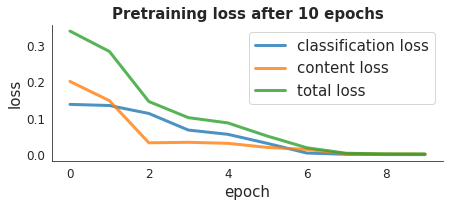

In [30]:
plot_pretraining_progress(
    experiment_n=5,
    title="Pretraining loss after 10 epochs",
    filename="+preepochs_GCN_progress",
    size=(7, 2.5),
)

If we now plot the generated distributions after training, we can see that the learned distribution is clearly affected by the number of pre-training epochs we use. The distribution in blue, the one for epoch 0, is not affected by the MMD training, so it's the produced distribution after pre-training. From this distribution we can see that the 10 epochs of pre-training help the GCN generate a similar distribution as the one specified in the probabilistic grammar. Furthermore, the use of learning rate decay keeps the distributions from collapsing to standard deviation 0, as can be seen in the following figure. This is important because it shows that the use of learning rate decay keeps the learned distribution through the MMD training epochs. This can specially be seen when we use 10 pre-training epochs and learning rate decay every 2 epochs.

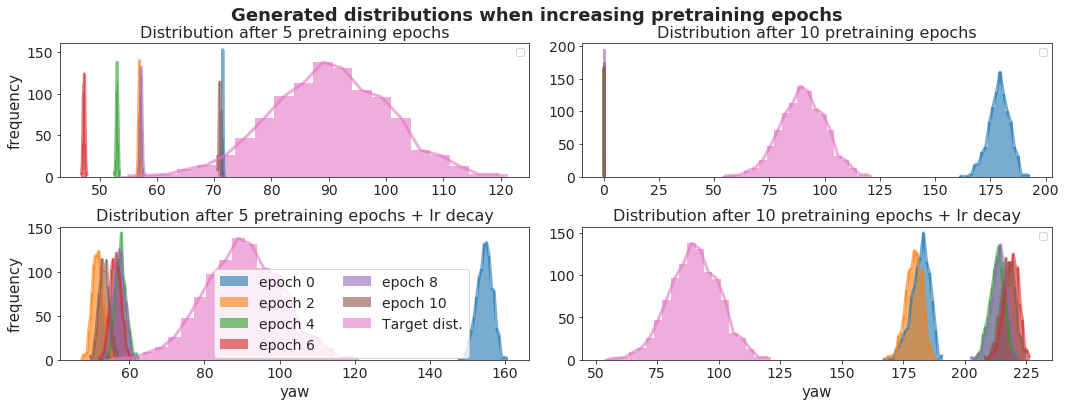

In [194]:
# Plot grid of distributions
titles = [
    "Distribution after 5 pretraining epochs",
    "Distribution after 10 pretraining epochs",
    "Distribution after 5 pretraining epochs + lr decay",
    "Distribution after 10 pretraining epochs + lr decay",
]
# Experiment list
exp_list = [4, 5, 7, 8]
# Plot distribution grid
plt.suptitle(
    "Generated distributions when increasing pretraining epochs",
    fontweight="bold",
    fontsize=18,
    y=1.02,
)
for i, exp in enumerate(exp_list):
    fig = plot_distribution_grid(
        experiment=exp, interval=2, size=(15, 5.5), title=titles[i], i=i
    )
    plt.legend("")
    if exp == 7:
        plt.legend(bbox_to_anchor=(0.6, 0.73), loc="upper center", fontsize=14, ncol=2)
    if exp <= 5:
        plt.xlabel(None)
    if exp == 5 or exp == 8:
        plt.ylabel(None)
plt.tight_layout()
plt.show()
fig.figure.savefig(
    os.path.join(RESULTS_PATH, f"+preepochs_yawdist.pdf"),
    bbox_inches="tight",
    pad_inches=0.1,
)

From the previous plots we can see that the architecture rather learns a closer mean to the target distribution, or learns to generate a distribution as specified in the probabilistic grammar. It however doesn't seem to be converging towards the target mean, and gets stuck in local minima around other angles. We can confirm this from the non-convergence observed in the MMD loss of the 4 cases shown below.

/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


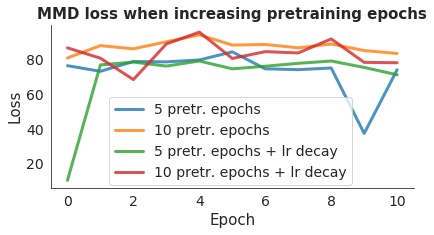

In [56]:
labels = [
    "5 pretr. epochs",
    "10 pretr. epochs",
    "5 pretr. epochs + lr decay",
    "10 pretr. epochs + lr decay",
]
sns.set_style("white")
fig, ax = plt.subplots(figsize=(6.5, 3))
exp_list = [4, 5, 7, 8]
for i, exp in enumerate(exp_list):
    plot_MMD_loss_joint(experiment_n=exp, label=labels[i])
    plt.legend(bbox_to_anchor=(0.85, 0.6), loc="upper right", fontsize=14)
plt.title(
    f"MMD loss when increasing pretraining epochs", fontweight="bold", fontsize=15
)
plt.xlabel("Epoch", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.despine(left=False, bottom=False)
plt.show()
fig.savefig(
    os.path.join(RESULTS_PATH, f"+preepochs_MMD_loss.pdf"),
    bbox_inches="tight",
    pad_inches=0.1,
)

If we look at the gradients, there seems to be no apparent vanishing gradient problem. In fact, the gradients seem to be healthier than the ones in our previous experiment. This may indicate that with this pre-training configuration, the architecture can learn, but the updates are too large, and therefore the learning is unstable. In later experiments, we may try to (1) reduce the learning rate we are using, and (2) implement weight decay. However, we must keep in mind that in this case the gradients are much higher than in the previous experiment, should we keep the gradients at a lower level so there is correct convergence?

/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


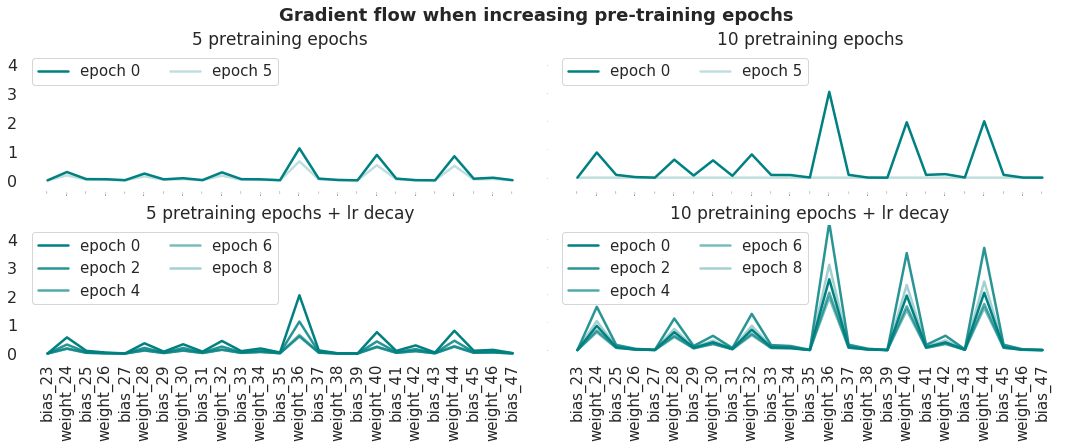

In [347]:
# Plot grid of distributions
titles = [
    "5 pretraining epochs",
    "10 pretraining epochs",
    "5 pretraining epochs + lr decay",
    "10 pretraining epochs + lr decay",
]
# Experiment list
exp_list = [4, 5, 7, 8]
# Plot distribution grid
plt.suptitle(
    "Gradient flow when increasing pre-training epochs",
    fontsize=18,
    fontweight="bold",
    y=1.03,
)
for i, exp in enumerate(exp_list):
    if exp == 4 or exp == 5:
        fig = plot_gradients_grid(
            experiment_n=exp,
            rows=2,
            columns=2,
            size=(15, 6),
            limit=10,
            alpha_mult=0.15,
            interval=5,
            title=titles[i],
            i=i,
        )
        plt.xticks(rotation=90, fontsize=0.05)
    else:
        fig = plot_gradients_grid(
            experiment_n=exp,
            rows=2,
            columns=2,
            size=(15, 6),
            limit=10,
            alpha_mult=0.08,
            interval=2,
            title=titles[i],
            i=i,
        )
    plt.ylim(top=4.5)
    plt.yticks(fontsize=16)
    if i % 2 != 0:
        plt.yticks(fontsize=0.001)

plt.tight_layout()
plt.show()
fig.figure.savefig(
    os.path.join(RESULTS_PATH, f"+preepochs_gradient_flow.pdf"),
    bbox_inches="tight",
    pad_inches=0.1,
)

### **4.1.1.4.2. Lowering the learning rate**
It seems clear now that in order to recreate the pre-defined distribution we need to use a significant amount of pre-training epochs, this amount increases as the graphs get more complicated (e.g. more nodes in the graphs, and more features). However, it is also evident now, from the results we have seen, that as we increase the number of pre-training epochs, the model is more susceptible to mode collapse. This is why we have to control the gradients in some way, we previously did this using learning rate decay, but in this set of experiments we will simply reduce the learning rate. 

Nevertheless, we are aware that the learning rate also affects the pre-training stage, so we will try a learning rate of 0.0005 and 0.0001 (so twice and 10 times smaller than the previous experiments), and then 0.0001 but pre-trained for 100 epochs, since in reality we are also slowing down pre-training progress when reducing the learning rate. This can clearly be seen in the following plots, which show the GCN pre-training performance.

In [57]:
RESULTS_PATH = "figures/single/1_attr/E_1"

/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


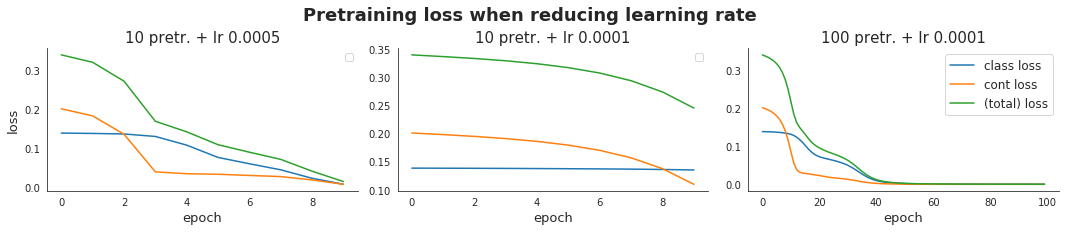

In [58]:
# Plot grid of distributions
titles = ["10 pretr. + lr 0.0005", "10 pretr. + lr 0.0001", "100 pretr. + lr 0.0001"]
# Experiment list
exp_list = [10, 11, 12]
# Plot distribution grid
plt.suptitle(
    "Pretraining loss when reducing learning rate",
    fontsize=18,
    fontweight="bold",
    y=1.06,
)
for i, exp in enumerate(exp_list):
    fig = plot_pretraining_progress_grid(experiment_n=exp, title=titles[i], i=i)
    plt.legend("")
    sns.despine(left=False, bottom=False)
    if i > 0:
        plt.ylabel(None)
    if i > 1:
        plt.legend(prop={"size": 12})

plt.tight_layout()
plt.show()
fig.figure.savefig(
    os.path.join(RESULTS_PATH, f"-lr_GCN_progress.pdf"),
    bbox_inches="tight",
    pad_inches=0.1,
)

From these plots we can see that the pre-training of the network is being slowed down by the low learning rate. This can be in reality harmful to our objective of learning a wider distribution predefined by the probabilistic grammar. This is why for such a low learning rate as 0.0001, we further increase the pretraining epochs to 100. From the third figure from left to right above we can see that the loss eventually converges to 0. This behavior is reflected in the produced distributions after 10 epochs of MMD training. We can see them below. 

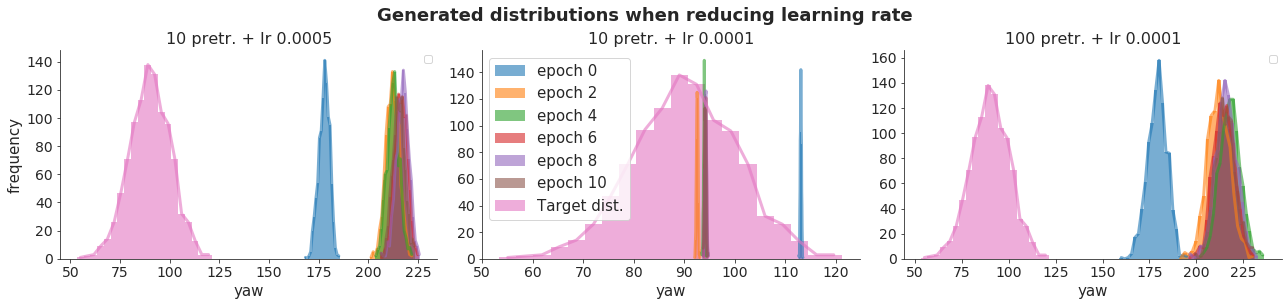

In [59]:
# Plot grid of distributions
titles = ["10 pretr. + lr 0.0005", "10 pretr. + lr 0.0001", "100 pretr. + lr 0.0001"]
# Experiment list
exp_list = [10, 11, 12]
# Plot distribution grid
plt.suptitle(
    "Generated distributions when reducing learning rate",
    fontweight="bold",
    fontsize=18,
    y=1.05,
)
for i, exp in enumerate(exp_list):
    fig = plot_distribution_grid(
        experiment=exp,
        rows=1,
        columns=3,
        interval=2,
        size=(18, 4),
        title=titles[i],
        i=i,
    )
    if i > 0:
        plt.ylabel(None)

    plt.legend("")
    if i == 1:
        plt.legend(loc="upper left", prop={"size": 15})
    sns.despine(left=False, bottom=False)
plt.tight_layout()
plt.show()
fig.figure.savefig(
    os.path.join(RESULTS_PATH, f"-lr_yawdist.pdf"), bbox_inches="tight", pad_inches=0.1
)

From the generated distributions we observe the same paradigm we have been trying to avoid. If we allow the pre-training of the network to minimize the loss up to 0, like in the case of a learning rate of 0.0005, the generated distributions will have a large standard deviation, that resembles the one specified in the probabilistic grammar. This can be seen for both the first and third plot fromn left to right. However, if we don't let it minimize the loss up to ~0, this allows the MMD training to learn a mean close to the target mean, but without a large standard deviation, much less the one specified in the probabilistic grammar. This is further observed in the MMD loss, where there is convergence for the learning rate of 0.0001 and 10 epochs, and not for the others.

/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


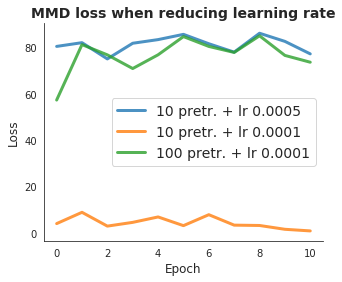

In [61]:
labels = ["10 pretr. + lr 0.0005", "10 pretr. + lr 0.0001", "100 pretr. + lr 0.0001"]
sns.set_style("white")
fig, ax = plt.subplots(figsize=(5, 4))
exp_list = [10, 11, 12]
for i, exp in enumerate(exp_list):
    plot_MMD_loss_joint(experiment_n=exp, label=labels[i])
plt.title(f"MMD loss when reducing learning rate", fontweight="bold", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
sns.despine(left=False, bottom=False)
plt.legend(loc="center right", prop={"size": 14})
plt.show()
fig.savefig(
    os.path.join(RESULTS_PATH, f"-lr_MMD_loss.pdf"), bbox_inches="tight", pad_inches=0.1
)

From these results we can see that using a leearning rate of 0.0001 and 10 epochs allows the network to converge towards a mean around 90 degrees, and therefore an MMD loss of around ~1. On the contrary, the other learning rates which were more agressive and allowed a "better" pre-training of the network don't allow it to converge. Once again this is reflected in the gradients of the network, which are signficantly higher for the experiments that did not converge.  

/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


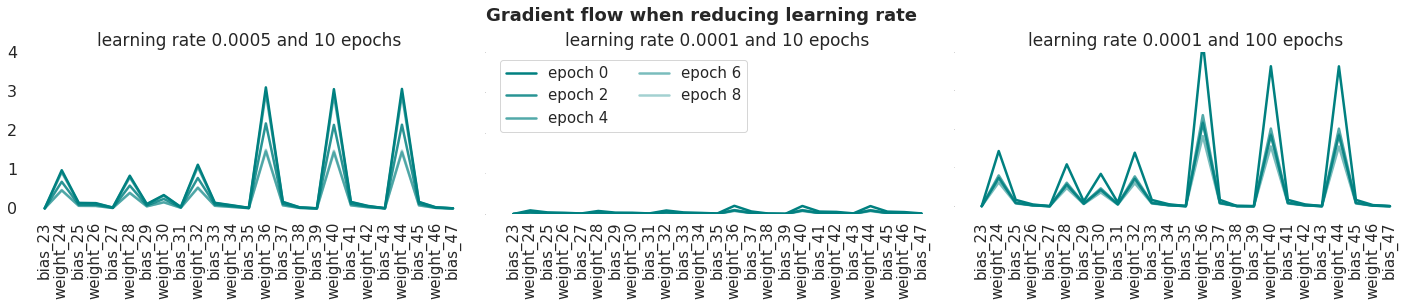

In [62]:
# Plot grid of distributions
titles = [
    "learning rate 0.0005 and 10 epochs",
    "learning rate 0.0001 and 10 epochs",
    "learning rate 0.0001 and 100 epochs",
]
# Experiment list
exp_list = [10, 11, 12]
# Plot distribution grid
plt.suptitle(
    "Gradient flow when reducing learning rate", fontweight="bold", fontsize=18, y=1.05
)
for i, exp in enumerate(exp_list):
    if i == 1:
        legend = False
    else:
        legend = True
    fig = plot_gradients_grid(
        experiment_n=exp,
        rows=1,
        columns=3,
        interval=2,
        size=(20, 4),
        limit=10,
        alpha_mult=0.08,
        title=titles[i],
        legend_none=legend,
        i=i,
    )
    plt.ylim(top=4)
    plt.yticks(fontsize=16)
    if i > 0:
        plt.yticks(fontsize=0.001)

plt.tight_layout()
plt.show()
fig.figure.savefig(
    os.path.join(RESULTS_PATH, f"-lr_gradient_flow.pdf"),
    bbox_inches="tight",
    pad_inches=0.1,
)

From this set of experiments, we can visualize the generated images from training with learning rate 0.0001 with 10 epochs of pretraining. This experiment does provide correct convergence, and the generated distribution is indeed slightly wider than the initial experiment that only used 1 pretraining epochs. In the following figure we can see the output of the renderer.

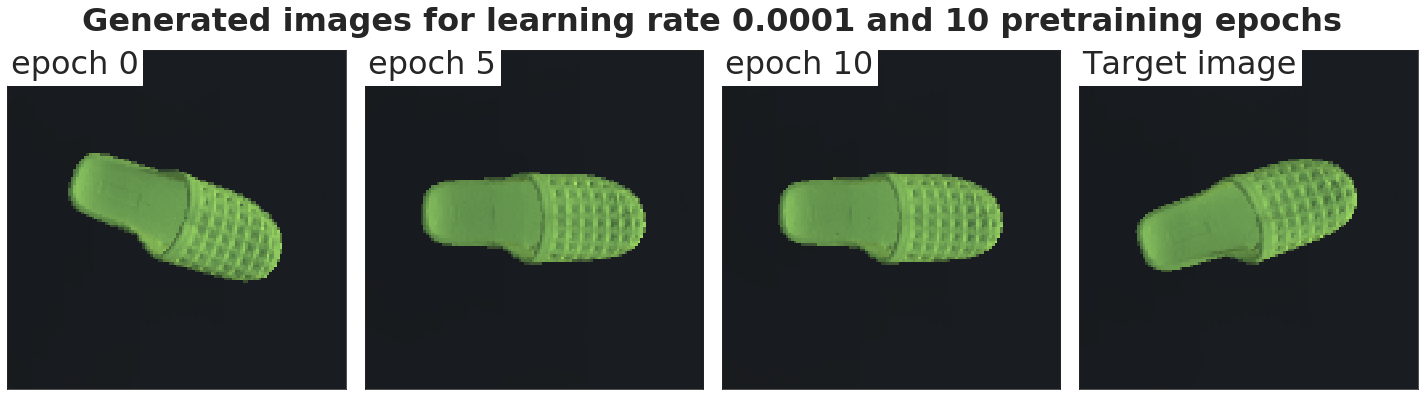

In [63]:
plot_each_image(
    experiment_n=11,
    interval=5,
    filename="-lr_images",
    title="Generated images for learning rate 0.0001 and 10 pretraining epochs",
)

### **4.1.1.4.3. Increasing weight decay (optional)**
According to the paper, and to previous experiments, it is indeed evident that it is during the pre-training phase that the GCN learns to generate a wider distribution, which is the one specified in the probabilistic grammar. This however, in our case, has shown to unstabilize learning of the target mean. In this set of experiments we gradually increase the number of reconstruction epochs to widen the generated distribution, while learning the correct mean.

In [82]:
RESULTS_PATH = "figures/single/1_attr/E_2"

#### Weight decay of 0.001

/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


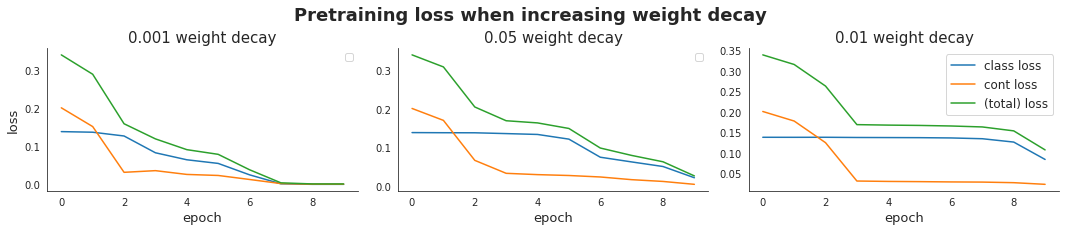

In [65]:
# Plot grid of distributions
titles = ["0.001 weight decay", "0.05 weight decay", "0.01 weight decay"]
# Experiment list
exp_list = [13, 14, 15]
# Plot distribution grid
plt.suptitle(
    "Pretraining loss when increasing weight decay",
    fontsize=18,
    fontweight="bold",
    y=1.06,
)
for i, exp in enumerate(exp_list):
    fig = plot_pretraining_progress_grid(experiment_n=exp, title=titles[i], i=i)
    plt.legend("")
    sns.despine(left=False, bottom=False)
    if i > 0:
        plt.ylabel(None)
    if i > 1:
        plt.legend(prop={"size": 12})

plt.tight_layout()
plt.show()
fig.figure.savefig(
    os.path.join(RESULTS_PATH, f"+weightdecay_GCN_progress.pdf"),
    bbox_inches="tight",
    pad_inches=0.1,
)

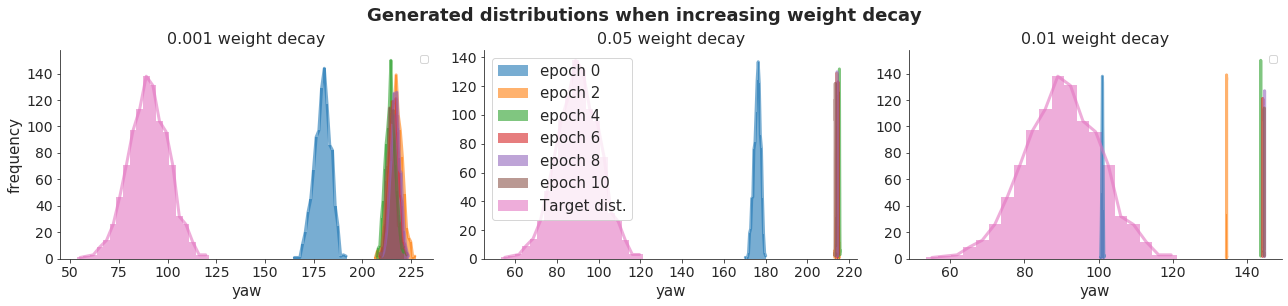

In [66]:
# Plot grid of distributions
titles = ["0.001 weight decay", "0.05 weight decay", "0.01 weight decay"]
# Experiment list
exp_list = [13, 14, 15]
# Plot distribution grid
plt.suptitle(
    "Generated distributions when increasing weight decay",
    fontweight="bold",
    fontsize=18,
    y=1.05,
)
for i, exp in enumerate(exp_list):
    fig = plot_distribution_grid(
        experiment=exp,
        rows=1,
        columns=3,
        interval=2,
        size=(18, 4),
        title=titles[i],
        i=i,
    )
    if i > 0:
        plt.ylabel(None)

    plt.legend("")
    if i == 1:
        plt.legend(loc="upper left", prop={"size": 15})
    sns.despine(left=False, bottom=False)
plt.tight_layout()
plt.show()
fig.figure.savefig(
    os.path.join(RESULTS_PATH, f"+weight_decay_yawdist.pdf"),
    bbox_inches="tight",
    pad_inches=0.1,
)

/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


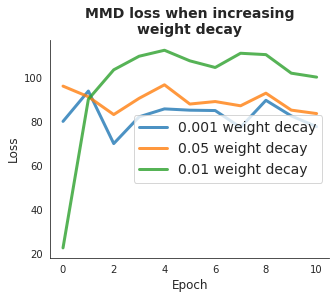

In [68]:
labels = ["0.001 weight decay", "0.05 weight decay", "0.01 weight decay"]
sns.set_style("white")
fig, ax = plt.subplots(figsize=(5, 4))
exp_list = [13, 14, 15]
for i, exp in enumerate(exp_list):
    plot_MMD_loss_joint(experiment_n=exp, label=labels[i])
plt.title(f"MMD loss when increasing\nweight decay", fontweight="bold", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
sns.despine(left=False, bottom=False)
plt.legend(loc="center right", prop={"size": 14})
plt.show()
fig.savefig(
    os.path.join(RESULTS_PATH, f"+weightdecay_MMD_loss.pdf"),
    bbox_inches="tight",
    pad_inches=0.1,
)

/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


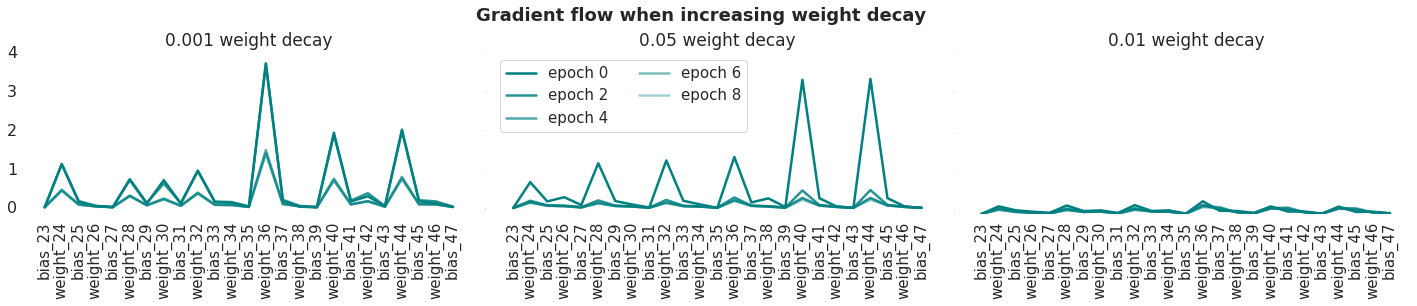

In [69]:
# Plot grid of distributions
titles = ["0.001 weight decay", "0.05 weight decay", "0.01 weight decay"]
# Experiment list
exp_list = [13, 14, 15]
# Plot distribution grid
plt.suptitle(
    "Gradient flow when increasing weight decay", fontweight="bold", fontsize=18, y=1.05
)
for i, exp in enumerate(exp_list):
    if i == 1:
        legend = False
    else:
        legend = True
    fig = plot_gradients_grid(
        experiment_n=exp,
        rows=1,
        columns=3,
        interval=2,
        size=(20, 4),
        limit=10,
        alpha_mult=0.08,
        title=titles[i],
        legend_none=legend,
        i=i,
    )
    plt.ylim(top=4)
    plt.yticks(fontsize=16)
    if i > 0:
        plt.yticks(fontsize=0.001)

plt.tight_layout()
plt.show()
fig.figure.savefig(
    os.path.join(RESULTS_PATH, f"+weightdecay_gradient_flow.pdf"),
    bbox_inches="tight",
    pad_inches=0.1,
)

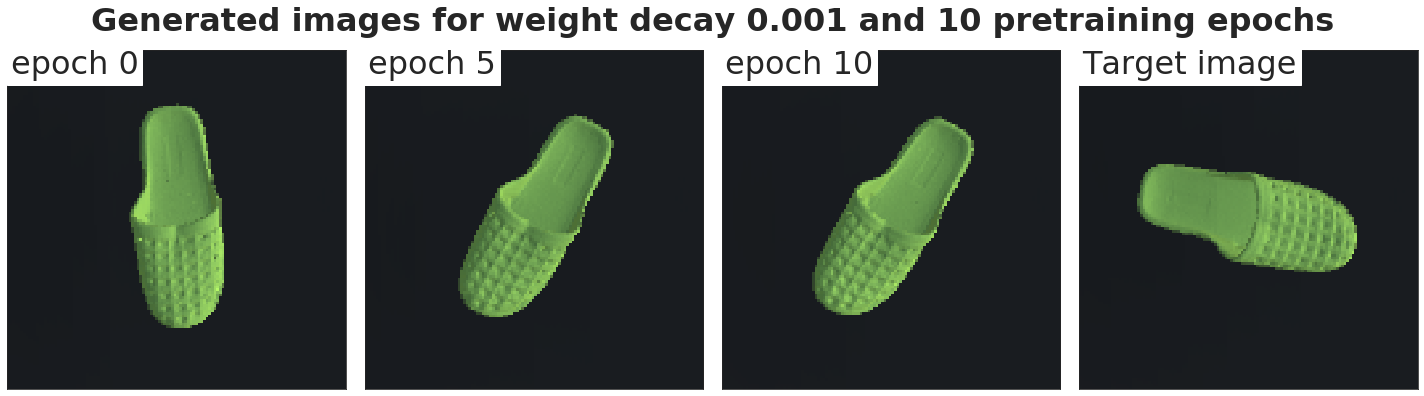

In [83]:
plot_each_image(
    experiment_n=13,
    interval=5,
    filename="+weightdecay_images",
    title="Generated images for weight decay 0.001 and 10 pretraining epochs",
)

### **4.1.1.4.4. 10 pre-training epochs, employing learning rate decay, and decreasing MMD loss multiplier (optional)**
According to the paper, and to previous experiments, it is indeed evident that it is during the pre-training phase that the GCN learns to generate a wider distribution, which is the one specified in the probabilistic grammar. This however, in our case, has shown to unstabilize learning of the target mean. In this set of experiments we gradually increase the number of reconstruction epochs to widen the generated distribution, while learning the correct mean.

In [84]:
RESULTS_PATH = "figures/single/1_attr/E_3"

#### Reducing the MMD multiplier to 50

/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


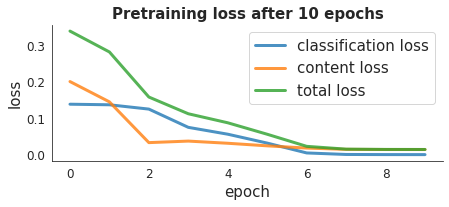

In [72]:
plot_pretraining_progress(
    experiment_n=16,
    title="Pretraining loss after 10 epochs",
    filename="-mmdmult_GCN_progress",
    size=(7, 2.5),
)

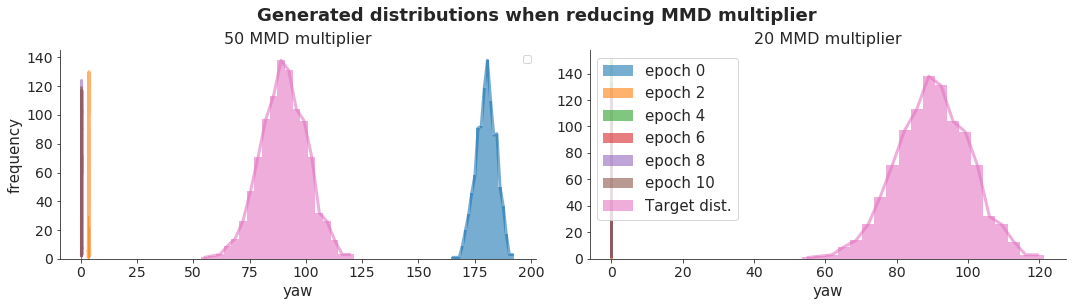

In [73]:
# Plot grid of distributions
titles = ["50 MMD multiplier", "20 MMD multiplier"]
# Experiment list
exp_list = [16, 17]
# Plot distribution grid
plt.suptitle(
    "Generated distributions when reducing MMD multiplier",
    fontweight="bold",
    fontsize=18,
    y=1.05,
)
for i, exp in enumerate(exp_list):
    fig = plot_distribution_grid(
        experiment=exp,
        rows=1,
        columns=2,
        interval=2,
        size=(15, 4),
        title=titles[i],
        i=i,
    )
    if i > 0:
        plt.ylabel(None)

    plt.legend("")
    if i == 1:
        plt.legend(loc="upper left", prop={"size": 15})
    sns.despine(left=False, bottom=False)
plt.tight_layout()
plt.show()
fig.figure.savefig(
    os.path.join(RESULTS_PATH, f"-mmdmult_yawdist.pdf"),
    bbox_inches="tight",
    pad_inches=0.1,
)

/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


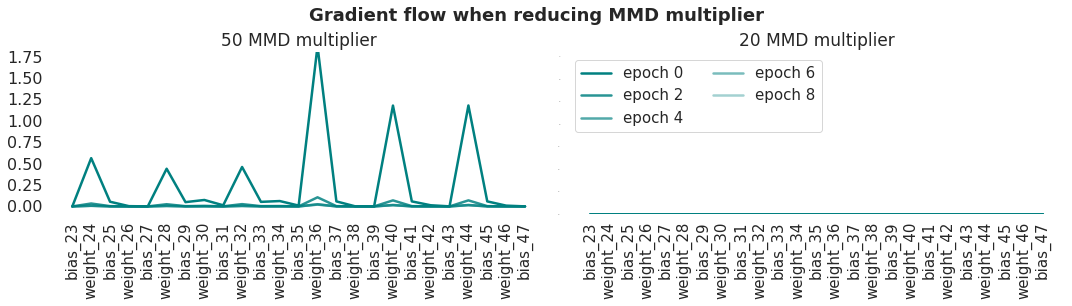

In [79]:
# Plot grid of distributions
titles = ["50 MMD multiplier", "20 MMD multiplier"]
# Experiment list
exp_list = [16, 17]
# Plot distribution grid
plt.suptitle(
    "Gradient flow when reducing MMD multiplier", fontweight="bold", fontsize=18, y=1.05
)
for i, exp in enumerate(exp_list):
    if i == 1:
        legend = False
    else:
        legend = True
    fig = plot_gradients_grid(
        experiment_n=exp,
        rows=1,
        columns=2,
        interval=2,
        size=(15, 4),
        limit=10,
        alpha_mult=0.08,
        title=titles[i],
        legend_none=legend,
        i=i,
    )
    plt.ylim(top=1.8)
    plt.yticks(fontsize=16)
    if i > 0:
        plt.yticks(fontsize=0.001)

plt.tight_layout()
plt.show()
fig.figure.savefig(
    os.path.join(RESULTS_PATH, f"-mmdmult_gradient_flow.pdf"),
    bbox_inches="tight",
    pad_inches=0.1,
)

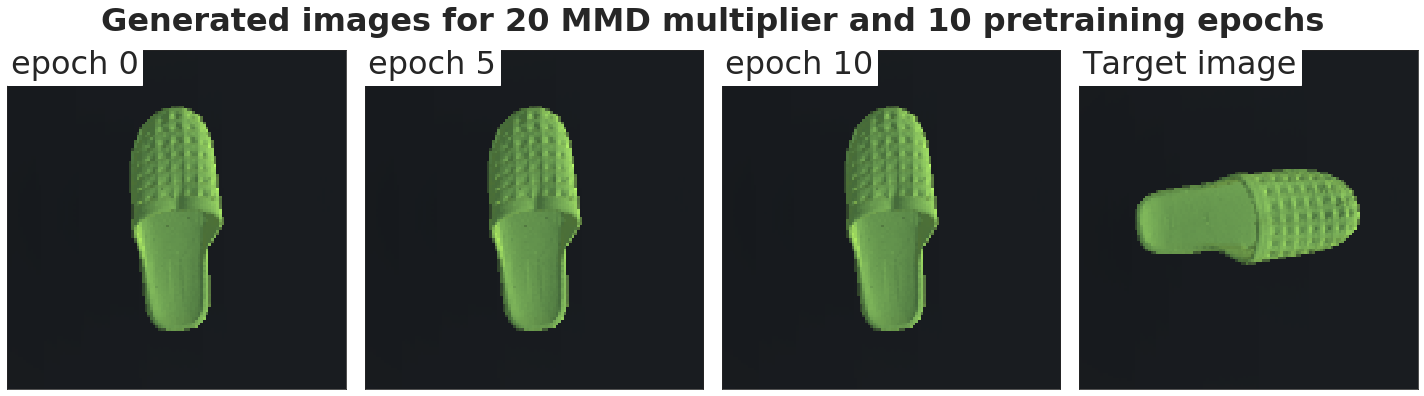

In [86]:
plot_each_image(
    experiment_n=17,
    interval=5,
    filename="-mmdmult_images",
    title="Generated images for 20 MMD multiplier and 10 pretraining epochs",
)

/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


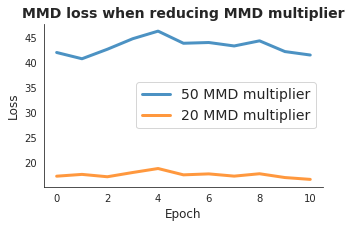

In [87]:
labels = ["50 MMD multiplier", "20 MMD multiplier"]
sns.set_style("white")
fig, ax = plt.subplots(figsize=(5, 3))
exp_list = [16, 17]
for i, exp in enumerate(exp_list):
    plot_MMD_loss_joint(experiment_n=exp, label=labels[i])
plt.title(f"MMD loss when reducing MMD multiplier", fontweight="bold", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
sns.despine(left=False, bottom=False)
plt.legend(loc="center right", prop={"size": 14})
plt.show()
fig.savefig(
    os.path.join(RESULTS_PATH, f"-mmdmult_MMD_loss.pdf"),
    bbox_inches="tight",
    pad_inches=0.1,
)

#### Reducing the MMD multiplier to 20

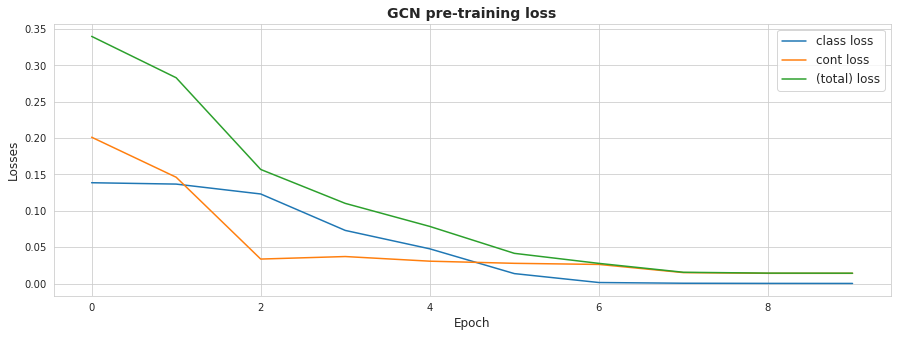

In [39]:
plot_pretraining_progress(experiment_n=17)

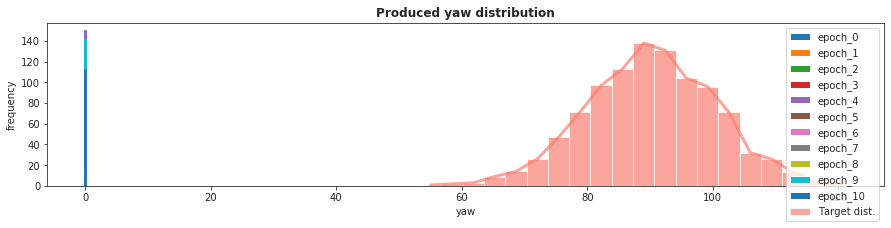

In [56]:
plot_distributions(experiment=17, interval=1)

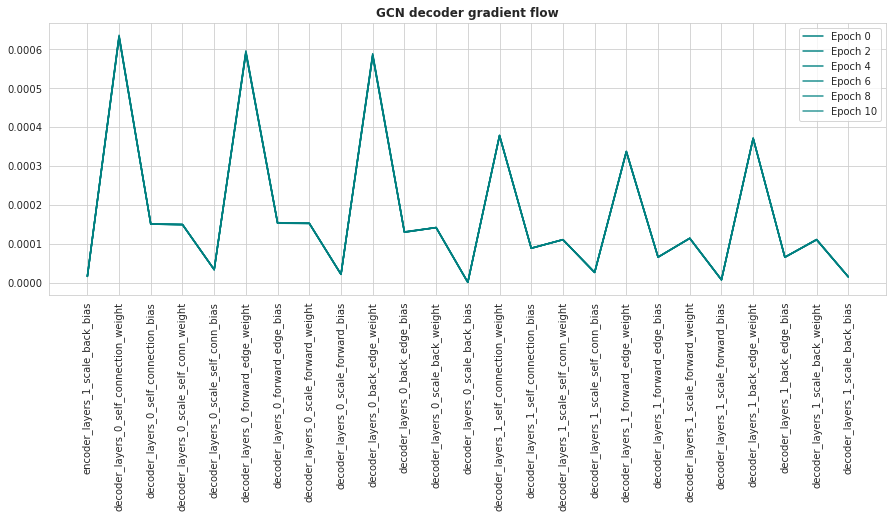

In [41]:
plot_gradients(experiment_n=17)

### **Conclusions of this part of the study**
After all the experiments performed during this section of the study, we can argue that the Meta-Sim architecture is not an architecture that scales to the simplest custom 3D case. The architecture's hyperparameters do not have a direct correlation to its convergence performance, and it only convergence on very specific hyperparameters, without keeping the pre-defined standard deviation, and only learning the mean. We will therefore move to using more complex scenes, in the hopes that the complexification of the graphs will regularize the instability of the learning during training on the MMD loss.

Maybe the perfect hyperparameters for this case are out there, however, this initial study shows that even with a thorough hyperparameter search like the one we just performed, the architecture isn't able to completely learn the target distribution on the simplest 3D case.

## **4.1.2. Learning to rotate an object 90 degrees and change its position on a single-class setting**
We now continue to complexify the scene, and the probabilistic grammar, in the hopes that this model will help regularize the high gradients we experienced before. We thus move to learning a distribution over the yaw attribute, but also the loc_x and loc_y attributes. The last two are initialized around 100, with a standard deviation of 15. The yaw distribution is left as before. 

Let us define the root path from which we will get the results from the experiments on 3 attributes.

In [8]:
ROOT_PATH = "../results/single/3_attr"
RESULTS_PATH = "figures/single/3_attr/4_1_2"

We start by allowing the model to fully play with the values of the locations, bearing in mind that the model can generate locations that take the object out of frame. For these experiments and for the rest, we stop exploring with other hyperparameters and stick to the number of reconstruction epochs, and learning rate decay, since these two proved the most impactful in the performance of the network. We prioritize exploring multiple scene variations over exploring all possible hyperparameter configurations, since this study seeks to evaluate how the provided Meta-Sim model works on an increasingly complex new 3D scene.

We start by looking at the generated yaw distributions after using 25, 50, 75 recaonstruction epochs, and 75 reconstruction epochs + learning rate decay. We use these values since we now want to be more precise in the initialization of the location, because if not, the model will collapse into values that take the object out of frame.

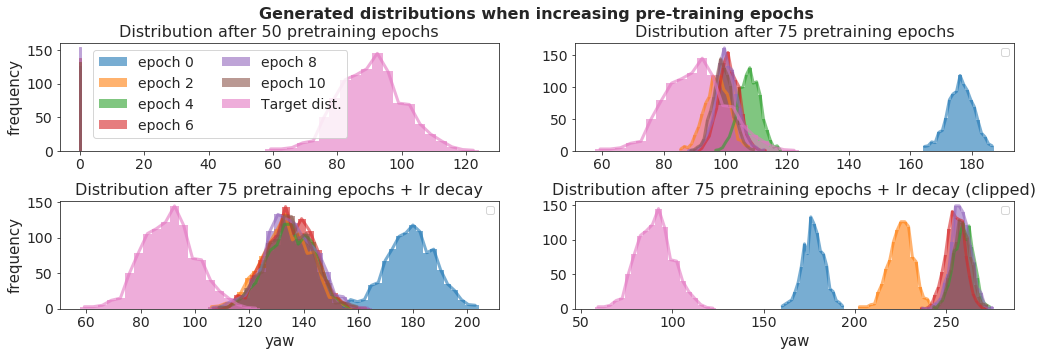

In [181]:
# Plot grid of distributions
titles = [
    "Distribution after 50 pretraining epochs",
    "Distribution after 75 pretraining epochs",
    "Distribution after 75 pretraining epochs + lr decay",
    "Distribution after 75 pretraining epochs + lr decay (clipped)",
]
# Experiment list
exp_list = [22, 23, 25, 26]
# Plot distribution grid
plt.suptitle(
    "Generated distributions when increasing pre-training epochs",
    fontsize=16,
    fontweight="bold",
    y=1.02,
)
for i, exp in enumerate(exp_list):
    fig = plot_distribution_grid(
        experiment=exp, interval=2, size=(15, 4.8), title=titles[i], i=i
    )
    plt.legend("")
    if exp == 22:
        plt.legend(
            loc="upper left", bbox_to_anchor=(0.06, 1), ncol=2, prop={"size": 14}
        )
    if i < 2:
        plt.xlabel(None)
    if i % 2 != 0:
        plt.ylabel(None)
plt.tight_layout()
plt.show()
fig.figure.savefig(
    os.path.join(RESULTS_PATH, f"single_3attr_yawdist.pdf"),
    bbox_inches="tight",
    pad_inches=0.1,
)

From the figure we can see that the architecture is not able to learn the yaw distribution correctlly after 25 or 50 epochs, since the distribution simply collapses to 0. However, interestingly enough, after 75 epochs of pretraining, the architecture is able to learn a correct distribution, and get very close to the target distribution's mean. Additionally, when we add learning rate decay, the predefined distribution is learned successfully with a wide enough standard deviation. However, this iteration does not learn a target mean correctly.

This however is not enough for us to conclude that the architecture is converging towards the target distribution. Let us now look at the generated distributions for the locations of the object. 

/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, Use

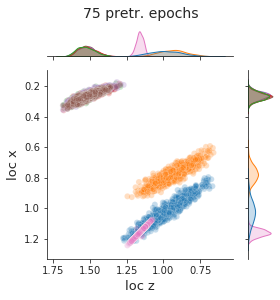

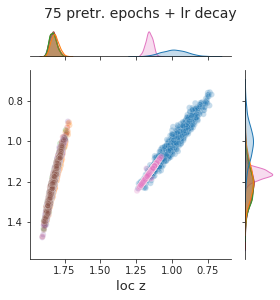

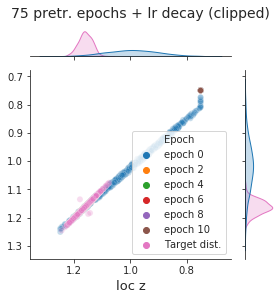

In [222]:
# Plot grid of distributions
titles = [
    "75 pretr. epochs",
    "75 pretr. epochs + lr decay",
    "75 pretr. epochs + lr decay (clipped)",
]
# Experiment list
exp_list = [23, 25, 26]
# Plot distribution grid
for i, exp in enumerate(exp_list):
    if exp == 23 or exp == 25:
        legend = False
    else:
        legend = True

    if i > 0:
        ylabel = False
    else:
        ylabel = True

    jointgrid = plot_loc_dist_grid(
        experiment_n=exp,
        title=titles[i],
        height=4,
        filename=f"single_3attr_locdistr_{i}",
        legend=legend,
        ylabel=ylabel,
    )

From the distributions of locations generated by the netowork we can see that the network is generating normal distributions stably after 75 reconstruction epochs, as well as yaw distributions, judging from the previous results. However, after epoch 0 the object is completely out of frame (this happens in locations in x and y above 1.25 and below 0.75). Indeed, after the second epoch of learning, the object is taken out of frame and the learning stagnates in a black screen, without any further updates. For this, in the last experiment we clip the locations of the objects to the frame of the camera, so it isn't driven out of frame and the network can still have some distribution input to perform the MMD calculation. This is the red encircled dot we see in the last plot, where all distributions are being mapped to that single spot for the rest of the training epochs.

As we can see from the MMD losses below, there is still no convergence from the architecture when increasing the number of modifiable attributes to 3. The arechitecture continues to have high gradients, as shown in the figure after, which in turn just completely offsets the learning to local optima, which in our case is a black screen.

/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


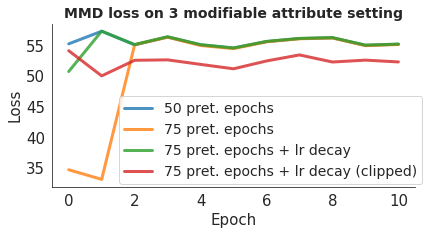

In [9]:
# Plot grid of distributions
labels = [
    "50 pret. epochs",
    "75 pret. epochs",
    "75 pret. epochs + lr decay",
    "75 pret. epochs + lr decay (clipped)",
]
sns.set_style("white")
fig, ax = plt.subplots(figsize=(6.5, 3))
exp_list = [22, 23, 25, 26]

for i, exp in enumerate(exp_list):
    plot_MMD_loss_joint(experiment_n=exp, label=labels[i])
    plt.legend(bbox_to_anchor=(1.04, 0.6), loc="upper right", fontsize=14)

plt.title(f"MMD loss on 3 modifiable attribute setting", fontweight="bold", fontsize=14)
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
sns.despine(left=False, bottom=False)
plt.show()
fig.savefig(
    os.path.join(RESULTS_PATH, f"single_3attr_MMD_loss.pdf"),
    bbox_inches="tight",
    pad_inches=0.1,
)

Furthermore, we can see that using 75 pretraining epochs helps the network converge during the first epoch.However, the next update is still so high that it brings the object out of frame, where all experiments arrive eventually and don't learn with a loss that oscillates around 55. We can further prove this by analyzing the gradients of the 4 networks. 

Also, clipping the locations of the objects lowers the general MMD, since the green spot is still in frame. However, this is still harmful to the ability of the network to learn a distribution, since we are mapping all distributions to a single dirac impulse. From the initial experiments, we have proven that this is not desirable, since it is really difficult for the distribution matching to attempt and match a Gaussian distribution to a dirac impulse. Therefore, for the rest of the experiments we map each sample that is driven out of frame by sampling from a Gaussian centered around just below the limit of the frame. This creates a normal distribution, instead of a single point where all samples are in.

/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


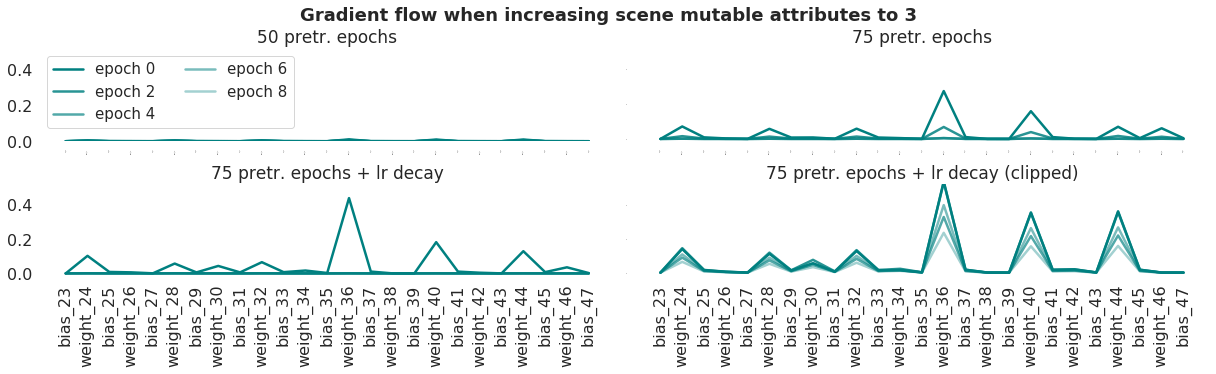

In [375]:
# Plot grid of distributions
titles = [
    "50 pretr. epochs",
    "75 pretr. epochs",
    "75 pretr. epochs + lr decay",
    "75 pretr. epochs + lr decay (clipped)",
]
# Experiment list
exp_list = [22, 23, 25, 26]
# Plot distribution grid
plt.suptitle(
    "Gradient flow when increasing scene mutable attributes to 3",
    fontsize=18,
    fontweight="bold",
    y=1.03,
)
for i, exp in enumerate(exp_list):
    if i > 0:
        fig = plot_gradients_grid(
            experiment_n=exp,
            rows=2,
            columns=2,
            interval=2,
            limit=10,
            alpha_mult=0.08,
            size=(17, 5),
            title=titles[i],
            legend_none=True,
            i=i,
        )
    else:
        fig = plot_gradients_grid(
            experiment_n=exp,
            rows=2,
            columns=2,
            interval=2,
            limit=10,
            alpha_mult=0.08,
            size=(17, 5),
            title=titles[i],
            legend_none=False,
            i=i,
        )
    if i < 2:
        plt.xticks(rotation=90, fontsize=0.01)
    else:
        plt.xticks(rotation=90, fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylim(top=0.52)

    if i % 2 != 0:
        plt.yticks(fontsize=0.001)


plt.tight_layout()
plt.show()
fig.figure.savefig(
    os.path.join(RESULTS_PATH, f"single_3attr_gradient_flow.pdf"),
    bbox_inches="tight",
    pad_inches=0.1,
)

From the gradients we can see that all experiments except for the one trained after 75 epochs are vanishing to 0 after the second epoch. This is to be expected according to the observed distributions, since they are being driven out of frame. However, there seems to be some indication of learning on the experment trained after 75 epochs. Indeed, this indicates that the MMD training is providing very large updates, and that the gradients at each epoch need to be kept in between 0.1 and 0.25 to allow healthy learning. It thus becomes an optimization stabilization problem, since the gradients from the finite-differences estimation are so choppy. To illustrate how the images are driven out of frame, we can see the following figure from the 75 epochs of pretraining.

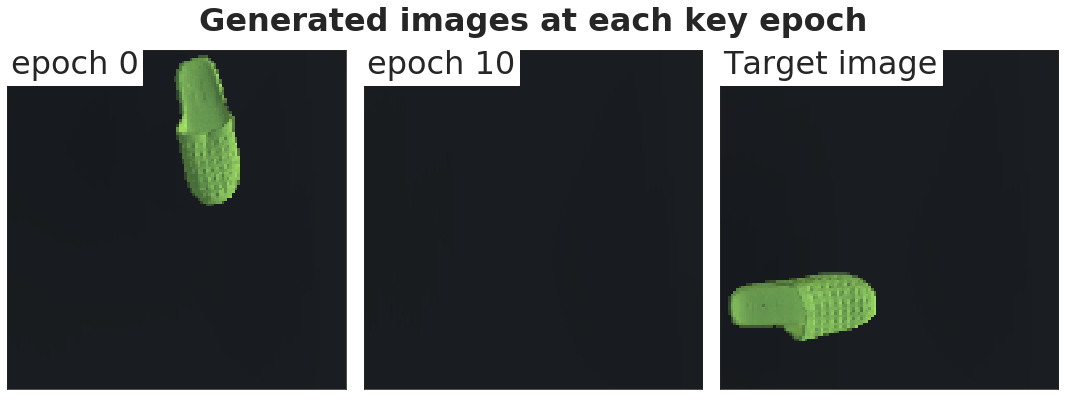

In [445]:
plot_each_image(
    experiment_n=23,
    interval=10,
    filename="single_3attr_images_woclipping",
    title="Generated images at each key epoch",
)

After epoch 2, since the model has full liberty over what location values to use, it sends the object out of the camera frame in the scene, the screen becomes black, and the learning stagnates. On the contrary, if we clip the locations of the objects, they still appear within frame, which in turn is helpful to MMD calculation. The generated images can be seen in the following figure.

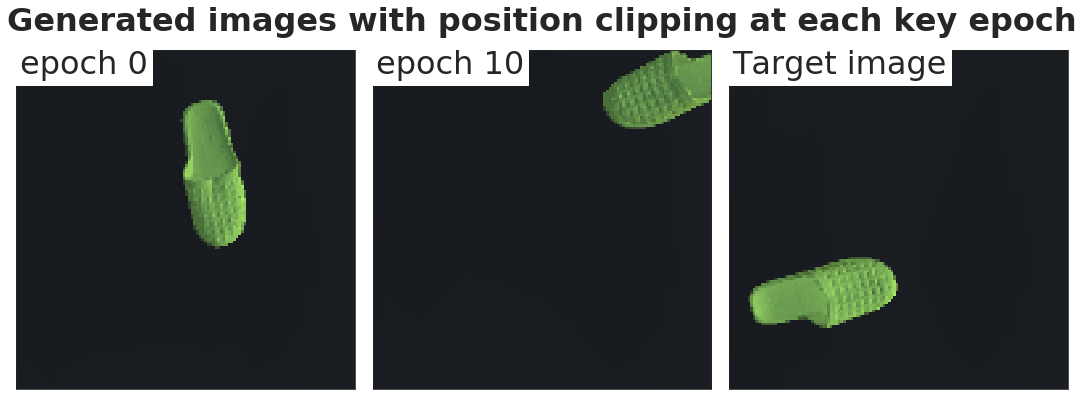

In [446]:
plot_each_image(
    experiment_n=26,
    interval=10,
    filename="single_3attr_images_wclipping",
    title="Generated images with position clipping at each key epoch",
)

## **4.1.3. Learning to fully rotate an object and change its position on a single-class setting**
We continue to complexify the scene by increasing the number of modifiable attributes to 5. We add the other rotation components of the object, so additionally to the _yaw_, we add _pitch_, and _roll_ of the object, plus both coordinates of its location. With this complexifying, we hope to continue to understand the model's performance in fitting precise target distributions of different target distributions of the modifiable parameters defined in the probabilistic grammar. Also, we decide to change the way in which we clip the locations of the object, since the previous way was just generating a dirac impulse in a given point in space, which made the learning much more difficult. In this case, and for all experiments moving forward, every time de object moves out of frame, we sample from a distribution with same variance as the original one, centered around were the object is slipping out of frame. This way we will still allow the model to compare two Gaussian distributions when doing the MMD calculation.

Let's define the root path from where the results are found.

In [491]:
ROOT_PATH = "../results/single/5_attr/"
RESULTS_PATH = "figures/single/5_attr/4_1_3"

We decide to run 4 experiments where we use 50, and 75 pretraining epochs, 100 pretraining epochs. With these experiments we wish to study the behavior of the distributions at each epoch in the MMD training, which will be run for 10 epochs as usual. We start by looking at the generated yaw, pitch, and roll distributions as a 3D plot. From this plot we can see that there is no apparent distribution matching happening, and we notice a similar pattern when there is no learning, which is the convergence of samples towards 0, in one or two of the angles. This is a clear sign that perhaps the pose of the object is not exactly well represented in the featurized representation of the images, and therefore is not really being learned.

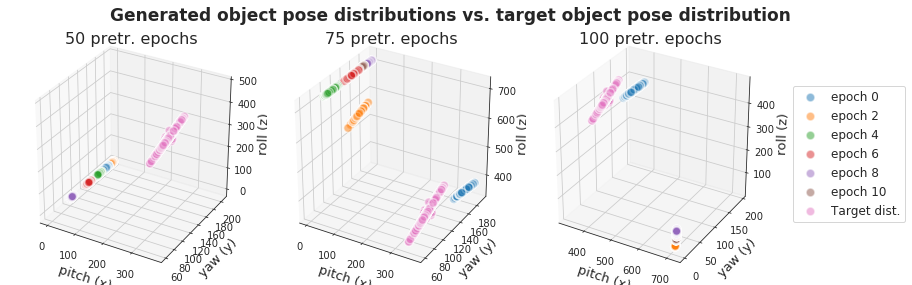

In [496]:
# Experiment list
exp_list = [1, 2, 3]

# Plot grid of distributions
title = "Generated object pose distributions vs. target object pose distribution"
sub_titles = ["50 pretr. epochs", "75 pretr. epochs", "100 pretr. epochs"]

# Plot full 3D plot
create_3D_rotation(
    exp_list=exp_list,
    interval=2,
    title=title,
    sub_titles=sub_titles,
    filename="single_5attr_fullrotdist",
)

We continue our analysis by looking at what the location of the generated samples were. For this, as before, we plot the distributions every 2 epochs of the 10 MMD training epochs. From these plots we can notice that the new Gaussian-clipping is working, and now the samples that are out of frame are brought back by sampling from a Gaussian distribution. This however doesn't seem to be enough for the model to learn to fit the target location distributions. We can actually observe that moving from 50 to 75 pretraining epochs shifts the location along z of the generated distributions towards the target distribution, but moves further away the location along x of the generated distribution. 

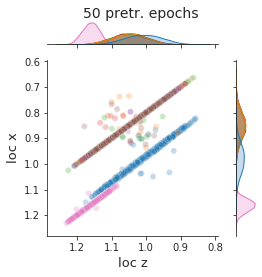

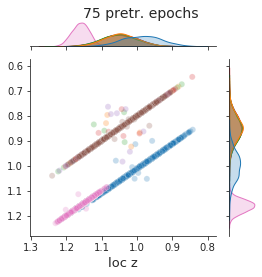

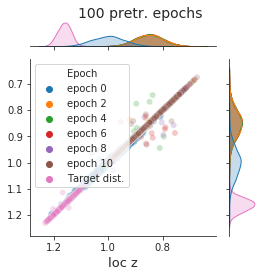

In [277]:
# Plot grid of distributions
titles = ["50 pretr. epochs", "75 pretr. epochs", "100 pretr. epochs"]
# Experiment list
exp_list = [1, 2, 3]
# Plot distribution grid
for i, exp in enumerate(exp_list):
    if exp == 1 or exp == 2:
        legend = False
    else:
        legend = True

    if i > 0:
        ylabel = False
    else:
        ylabel = True
    plot_loc_dist_grid(
        experiment_n=exp,
        height=4,
        filename=f"single_5attr_locdistr_{i}",
        title=titles[i],
        legend=legend,
        ylabel=ylabel,
    )

The architecture doesn't seem to be learning at all. This can be confirmed by looking at the MMD loss from the 3 experiments where the experiment with 50 pretraining epochs seems to have the lowest loss, but still doesn't seem to be learning, since there seems to be no convergence.

/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


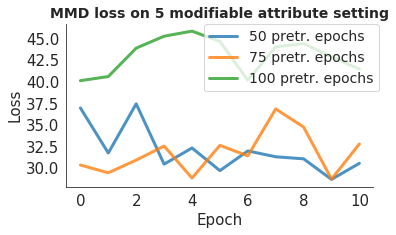

In [78]:
labels = ["50 pretr. epochs", "75 pretr. epochs", "100 pretr. epochs"]
sns.set_style("white")
fig, ax = plt.subplots(figsize=(5.5, 3))
exp_list = [1, 2, 3]
for i, exp in enumerate(exp_list):
    plot_MMD_loss_joint(experiment_n=exp, label=labels[i], limit=100)
    plt.legend(bbox_to_anchor=(1.04, 1.04), loc="upper right", fontsize=14)
plt.title(f"MMD loss on 5 modifiable attribute setting", fontweight="bold", fontsize=14)
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
sns.despine(left=False, bottom=False)
plt.show()
fig.savefig(
    os.path.join(RESULTS_PATH, f"single_5attr_MMD_loss.pdf"),
    bbox_inches="tight",
    pad_inches=0.1,
)

/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


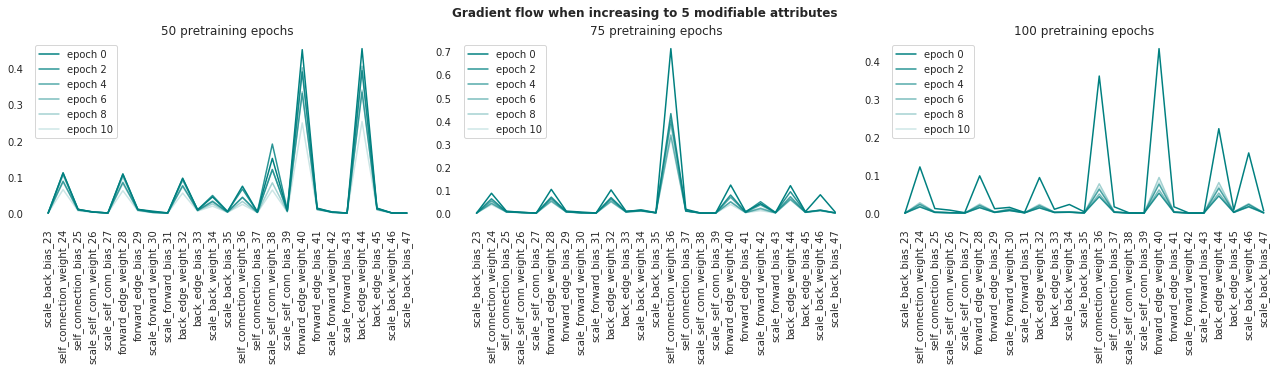

In [35]:
# Plot grid of distributions
titles = ["50 pretraining epochs", "75 pretraining epochs", "100 pretraining epochs"]
# Experiment list
exp_list = [1, 2, 3]
# Plot distribution grid
plt.suptitle(
    "Gradient flow when increasing to 5 modifiable attributes",
    fontweight="bold",
    y=1.02,
)
for i, exp in enumerate(exp_list):
    fig = plot_gradients_grid(
        experiment_n=exp,
        rows=1,
        columns=3,
        size=(18, 5),
        interval=2,
        title=titles[i],
        limit=11,
        alpha_mult=0.08,
        i=i,
    )
plt.tight_layout()
plt.show()
fig.figure.savefig(
    os.path.join(RESULTS_PATH, f"single_5attr_gradient_flow.pdf"),
    bbox_inches="tight",
    pad_inches=0.1,
)

We can look at the generated images from the experiment with 50 pretraining epochs. We can see that from epoch 0 to epoch 8 there seems to be learning of the target rotation along y (yaw), but no rotation along the other axis is being learned. Furthermore, the location of the object is also being moved, but it looks like there is no clear pattern rather than some general convergence towards the right center position in the frame.

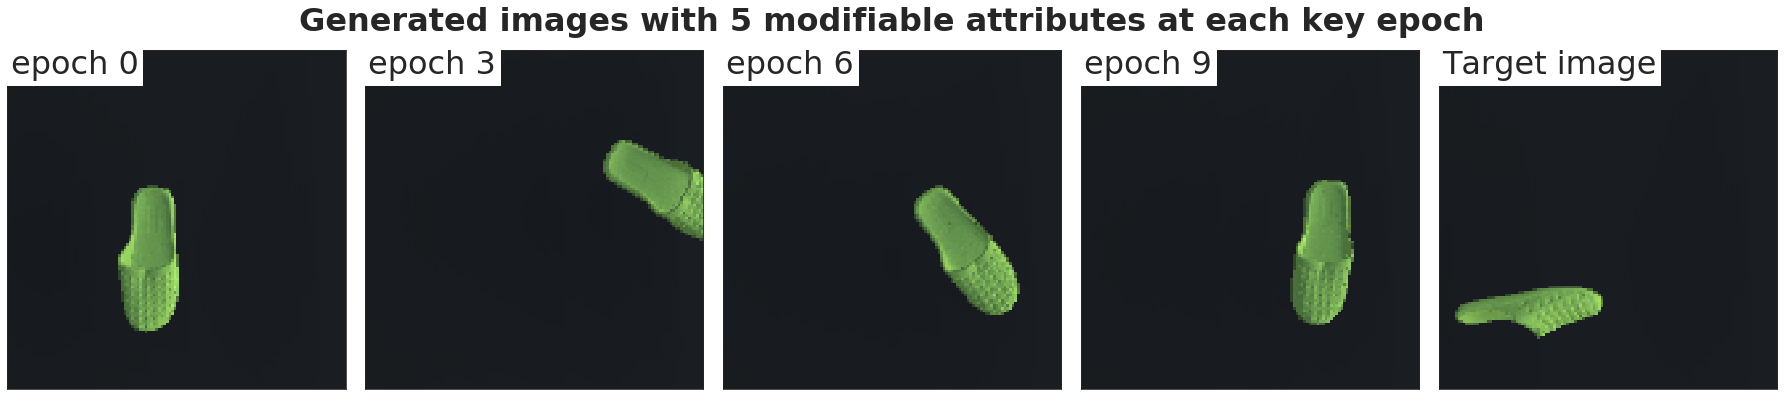

In [449]:
plot_each_image(
    experiment_n=1,
    interval=3,
    filename="single_5attr_images",
    title="Generated images with 5 modifiable attributes at each key epoch",
)

## **4.1.4. Adding more nodes: learning to rotate the camera and change light intensity**
We continue to complexify the scene by increasing the number of modifiable attributes to 8. We decide to include more nodes in the graph, so now we include information about the rotation of the camera that is taking the picture, and the light in the scene. The number of nodes goes from 4 to 6, and the number of modifiable attributes goes from 5 to 8, compared to the previous set of experiments. We therefore add two attributes that modify the rotation of the camera, _camera\_roll_ and _camera\_pitch_, and the _intensity_ of the light. Both are defined as Gaussians with given means and standard deviations (maybe specify this or provide in annex maybe?).

Let's define the root path from where the results are found.

In [278]:
ROOT_PATH = "../results/single/8_attr"
RESULTS_PATH = "figures/single/8_attr/4_1_4"

We can look at the camera attributes to verify whether the architecture is learning to shift the distribution towards the target distribution. Let's look at the camrea roll, pitch distributions in the following figure. From this figure we can see that the architecture is stuck at around 50 degrees for both attributes. This is a clear sign that the architecture is simply not learning.

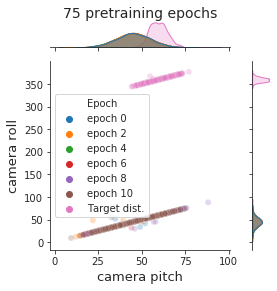

In [279]:
# Plot grid of distributions
titles = ["75 pretraining epochs"]
# Experiment list
exp_list = [2]
# Plot distribution grid
for i, exp in enumerate(exp_list):
    plot_camera_dist_grid(
        experiment_n=exp,
        interval=1,
        height=4,
        filename=f"single_8attr_camdistr_{i}",
        title=titles[i],
        legend=True,
        ylabel=True,
    )

This can be confirmed by plotting the MMD loss. From this plot we can clearly see no apparent sign of learning, or even convergence in this amount of epochs. Let's confirm it isn't because we are training it for too little epochs by looking at the gradients through the GCN decoder in Figure X. 

/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


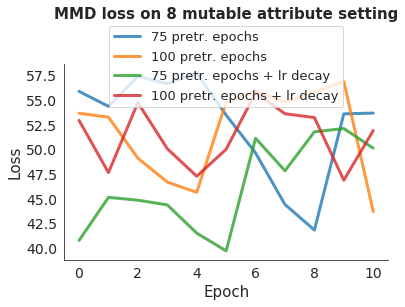

In [103]:
labels = [
    "75 pretr. epochs",
    "100 pretr. epochs",
    "75 pretr. epochs + lr decay",
    "100 pretr. epochs + lr decay",
]
sns.set_style("white")
fig, ax = plt.subplots(figsize=(5.8, 3.6))
exp_list = [2, 3, 4, 5]
for i, exp in enumerate(exp_list):
    plot_MMD_loss_joint(experiment_n=exp, label=labels[i], limit=100)
    plt.legend(bbox_to_anchor=(0.5, 1.23), loc="upper center", fontsize=13)
plt.title(
    f"MMD loss on 8 mutable attribute setting", fontweight="bold", fontsize=15, y=1.2
)
plt.xlabel("Epoch", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.despine(left=False, bottom=False)
plt.show()
fig.savefig(
    os.path.join(RESULTS_PATH, f"single_8attr_MMD_loss.pdf"),
    bbox_inches="tight",
    pad_inches=0.1,
)

By looking at the gradients we can quickly see that the gradients have completely vanished since the first epoch of learning. This may be due to the high complexity of the graph representing the scene, and the number of attributes used only one single object. In the next section we will explore a multi-class setting, hoping that this can help as a "regularizer" for the problems encountered with the single-class setting.

/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


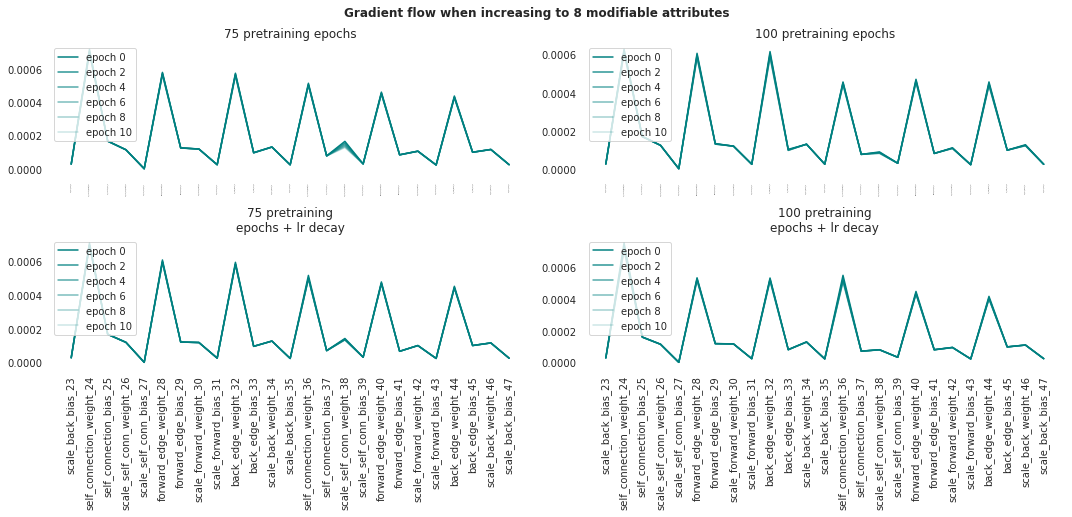

In [66]:
# Plot grid of distributions
titles = [
    "75 pretraining epochs",
    "100 pretraining epochs",
    "75 pretraining\nepochs + lr decay",
    "100 pretraining\nepochs + lr decay",
]
# Experiment list
exp_list = [2, 3, 4, 5]
# Plot distribution grid
plt.suptitle(
    "Gradient flow when increasing to 8 modifiable attributes",
    fontweight="bold",
    y=1.02,
)
for i, exp in enumerate(exp_list):
    if exp == 2 or exp == 3:
        fig = plot_gradients_grid(
            experiment_n=exp,
            rows=2,
            columns=2,
            size=(15, 7),
            interval=2,
            title=titles[i],
            limit=11,
            alpha_mult=0.08,
            i=i,
        )
        plt.xticks(rotation=90, fontsize=0.05)
    else:
        fig = plot_gradients_grid(
            experiment_n=exp,
            rows=2,
            columns=2,
            size=(15, 7),
            interval=2,
            title=titles[i],
            limit=11,
            alpha_mult=0.08,
            i=i,
        )
plt.tight_layout()
plt.show()
fig.figure.savefig(
    os.path.join(RESULTS_PATH, f"single_8attr_gradient_flow.pdf"),
    bbox_inches="tight",
    pad_inches=0.1,
)